<a href="https://colab.research.google.com/github/garychumd/highflow/blob/master/Harrison%20Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#necessary to run
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns
import xgboost as xgb
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#necessary to run
drive.mount("drive", force_remount=True)

Mounted at drive


In [3]:
#necessary to run
df = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Covid Data/Covid Master 300B.csv', header=1, dtype=str)

In [4]:
df.head(10)

,Case #,Admission Date,Age,Sex,Ethnicity,Zip code,DM,HTN,Prior MI (Stent CABG),CHF (HFrEF),CHF (HFpEF),OSA,Sick Contact hospitalized?,Chronic Lung Disease (COPD etc),Immunne suppressed / Transplant,Liver Cirrhosis,ESRD on HD,Active Smoker / Vaping,Fomer smoker / vaper,Active pregnancy,BMI,Weight (kg),SBP,DBP,P,R,Rom Air Sat,Temp (F),Zero to 60 L oxygen,Oxyen sat on highest oxygen,CPAP / BiPAP,Intubation,HGBA1c (+/1 100 days),WBC,HGB,Creat,ALT,TBILI,CRP,DDimer,Ferritin,LDH,Decadron,Remdesivir,Convalesent Plasma,SBP.1,DBP.1,P.1,R.1,Temp (F).1,Zero to 60 L oxygen.1,Oxyen sat on highest oxygen.1,CPAP / BiPAP.1,Intubation.1,WBC.1,HGB.1,Creat.1,ALT.1,TBILI.1,CRP.1,DDimer.1,Ferritin.1,LDH.1,Zero to 60 L oxygen.2,Oxyen sat on highest oxygen.2,CPAP / BiPAP.2,Intubation.2,Dead in 30 days,Crash > 4 days
0,1,6/14/2020,46,M,Latino,95822,no,no,no,no,no,no,no,no,no,no,no,no,no,no,28.87,102,139,71,117,24,75,103.3,6,91,no,no,6.2,14.4,10.9,0.86,37,0.8,14.5,0.57,652,375,yes,yes,no,115,65,78,28,99.9,60,97,yes,no,12.5,10.5,0.62,31,0.4,17,0.97,1111,684,yes,92,yes,no,no,NaN
1,2,6/16/2020,50,M,Latino,95624,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,26.37,88.2,129,82,112,20,85,101,5,94,no,no,5.5,9.4,16.8,0.77,115,0.4,14.6,NaN,1443,621,yes,yes,no,126,83,68,20,98.2,12,93,no,no,8,16.3,0.68,79,0.5,6.3,0.82,1472,361,yes,93,no,no,no,NaN
2,3,6/28/2020,85,M,Latina,95632,yes,yes,yes,yes,no,no,no,no,no,no,no,no,yes,no,29.42,80.2,151,71,80,16,96,99,0,96,no,no,9.2,8.4,9.6,2.46,8,0.9,NaN,NaN,NaN,NaN,no,no,no,134,66,100,24,100.3,2,99,no,no,9.8,10.1,2.34,10,0.8,23.9,2.62,244,252,no,96,no,no,no,yes
3,4,6/28/2020,82,M,Latino,95828,yes,no,no,no,no,no,yes,yes,no,no,no,no,no,no,30.26,75.8,115,67,88,20,93,99.9,0,93,no,no,7.3,4.8,14.7,1.08,35,0.5,NaN,NaN,NaN,NaN,yes,yes,no,127,70,64,26,97.5,6,90,no,no,4.9,14.2,0.98,36,0.3,NaN,0.3,10,1300,yes,94,yes,no,yes,NaN
4,5,7/1/2020,66,F,Caucasian,95823,no,no,no,no,no,no,no,no,no,no,no,no,no,no,18.72,49.5,163,84,118,20,83,100.8,30,98,no,no,5.5,6.2,12.4,2.05,19,0.5,NaN,NaN,NaN,NaN,yes,no,no,107,94,92,20,97.9,40,95,no,no,7.2,11.4,0.77,18,0.2,23.9,NaN,184,537,yes,90,yes,no,no,NaN
5,6,7/4/2020,83,M,Caucasian,95693,yes,yes,no,no,no,no,no,yes,no,no,no,no,yes,no,29,97,140,61,106,18,93,100.1,0,93,no,no,6.8,8.8,15.7,0.78,31,0.9,0.8,NaN,589,153,yes,no,no,124,61,61,19,97.3,2,96,no,no,12.3,13.5,0.67,26,0.8,1.4,1.03,680,158,no,97,no,no,no,yes
6,7,7/5/2020,65,M,Hmong,95820,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,25.02,70.3,133,82,114,28,85,98.8,2,97,no,no,10,9.8,12.2,1.24,22,0.6,8,0.32,533,336,yes,yes,no,137,80,94,24,98,40,94,no,no,10.6,12.1,0.85,16,1,9.4,0.45,569,365,yes,96,no,yes,no,NaN
7,8,7/9/2020,45,M,Caucasian,95820,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,40.05,141.5,148,89,111,22,89,102.9,2,97,no,no,6,5.3,15.9,0.65,31,0.5,10.9,0.41,1044,621,yes,no,no,131,73,94,18,98.7,6,95,no,no,8,11,0.57,21,0.4,12.7,0.61,1027,653,yes,95,no,no,no,NaN
8,9,7/10/2020,79,M,Latino,95632,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,33.11,95.9,141,76,77,19,90,98.5,2,96,no,no,8.6,5.6,13.1,1.47,22,0.8,9.1,0.58,892,491,yes,no,no,180,82,70,20,98.7,35,92,no,no,8.7,13.2,0.62,18,0.8,4.2,0.78,NaN,474,yes,96,no,no,yes,NaN
9,10,7/11/2020,76,F,Caucasian,95823,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,33.34,83,124,55,120,24,81,101.2,4,98,no,no,7.4,5.8,11.6,0.85,26,0.6,10.4,0.54,285,225,yes,no,no,100,53,75,22,98.2,6,91,no,no,7.8,11.5,0.61,37,0.4,5.9,0.34,397,292,yes,91,yes,no,no,transfer to ICU on day 3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Case #                           302 non-null    object
 1   Admission Date                   302 non-null    object
 2   Age                              302 non-null    object
 3   Sex                              302 non-null    object
 4   Ethnicity                        302 non-null    object
 5   Zip code                         302 non-null    object
 6   DM                               302 non-null    object
 7   HTN                              302 non-null    object
 8   Prior MI (Stent CABG)            302 non-null    object
 9   CHF (HFrEF)                      302 non-null    object
 10  CHF (HFpEF)                      302 non-null    object
 11  OSA                              302 non-null    object
 12  Sick Contact hospitalized?       302

In [6]:
yesNoList = ['DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
'OSA','Sick Contact hospitalized?','Chronic Lung Disease (COPD etc)','Immunne suppressed / Transplant',
'Liver Cirrhosis','ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy',
'CPAP / BiPAP','Intubation','Decadron','Remdesivir','Convalesent Plasma', 'CPAP / BiPAP.1', 'Intubation.1',
'CPAP / BiPAP.2','Intubation.2','Dead in 30 days','Crash > 4 days', 'Zero to 60 L oxygen.2']
convertDict = {'Age':float, 'Zip code':float, 'BMI':float, 'Weight (kg)':float, 'SBP':float, 'DBP':float, 'P':float, 'R':float,
               'Rom Air Sat':float, 'Temp (F)':float, 'Zero to 60 L oxygen':float,
               'Oxyen sat on highest oxygen':float, 'HGBA1c (+/1 100 days)':float, 'WBC':float,
               'HGB':float, 'Creat':float, 'ALT':float, 'TBILI':float, 'CRP': float, 'DDimer': float,
	       'Ferritin':float, 'LDH':float, 'SBP.1':float, 'DBP.1': float, 'P.1':float, 'R.1':float,
               'Temp (F).1':float, 'Zero to 60 L oxygen.1':float, 'Oxyen sat on highest oxygen.1':float,
               'WBC.1':float, 'HGB.1':float, 'Creat.1':float, 'ALT.1':float, 'TBILI.1':float,
               'CRP.1':float, 'DDimer.1':float, 'Ferritin.1':float, 'LDH.1':float, 'DM':bool, 'HTN':bool,
	       'Prior MI (Stent CABG)':bool, 'Chronic Lung Disease (COPD etc)':bool, 'ESRD on HD':bool,
	       'CPAP / BiPAP':bool, 'Intubation':bool, 'Decadron':bool, 'Remdesivir':bool, 'Convalesent Plasma':bool,
	       'CPAP / BiPAP.1':bool, 'Intubation.1':bool, 'Dead in 30 days':bool
               }

for i in yesNoList:
    df[i] = df[i].map({'yes':True, 'no':False, 'Yes':True, 'No':False, 'yes ':True, 'no ':False, 'yes  ':True, 'no  ':False, ' yes':True, ' no':False})
df['Sex'] = df['Sex'].map({'M': False, 'F': True})
df = df.astype(convertDict)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Case #                           302 non-null    object 
 1   Admission Date                   302 non-null    object 
 2   Age                              302 non-null    float64
 3   Sex                              302 non-null    bool   
 4   Ethnicity                        302 non-null    object 
 5   Zip code                         302 non-null    float64
 6   DM                               302 non-null    bool   
 7   HTN                              302 non-null    bool   
 8   Prior MI (Stent CABG)            302 non-null    bool   
 9   CHF (HFrEF)                      302 non-null    bool   
 10  CHF (HFpEF)                      302 non-null    bool   
 11  OSA                              302 non-null    bool   
 12  Sick Contact hospitali

In [8]:
#Remdesivir has flip flopped pi chart, 0 to 60L oxygen.2 as well

In [9]:
#output the number of deaths and the number of total cases
print("Total number of Deaths:")
print(len(df.loc[df['Dead in 30 days'] == 1]))
print("")
print("Total number of Deaths: " + str(len(df.loc[df['Dead in 30 days'] == 1])))
print("Total Cases: " + str(len(df)))
print("Mortality Rate: " + str(len(df.loc[df['Dead in 30 days'] == 1])/len(df)))

Total number of Deaths:
39

Total number of Deaths: 39
Total Cases: 302
Mortality Rate: 0.1291390728476821


In [10]:
print("Remdesivir:")
print(len(df.loc[df['Remdesivir'] == 1]))
print("")
print("Patients given Remdesivir: " + str(len(df.loc[df['Remdesivir'] == 1])))
print("Total Cases: " + str(len(df)))
print("Remdesivir usage Rate: " + str(len(df.loc[df['Remdesivir'] == 1])/len(df)))

Remdesivir:
133

Patients given Remdesivir: 133
Total Cases: 302
Remdesivir usage Rate: 0.44039735099337746


In [11]:
print("0 to 60L Oxygen:")
print(len(df.loc[df['Zero to 60 L oxygen.2'] == 1]))
print("")
print("Total number given Oxygen: " + str(len(df.loc[df['Zero to 60 L oxygen.2'] == 1])))
print("Total Cases: " + str(len(df)))
print("Percentage given Oxygen: " + str(len(df.loc[df['Zero to 60 L oxygen.2'] == 1])/len(df)))

0 to 60L Oxygen:
136

Total number given Oxygen: 136
Total Cases: 302
Percentage given Oxygen: 0.4503311258278146


In [14]:
#Crash > 4 days
print("Requiring advanced Oxygen support on day 4:")
print(len(df.loc[df['Crash > 4 days'] == 1]))
print("")
print("Total number crashes: " + str(len(df.loc[df['Crash > 4 days'] == 1])))
print("Total Cases: " + str(len(df)))
print("Percentage crash: " + str(len(df.loc[df['Crash > 4 days'] == 1])/len(df)))

Requiring advanced Oxygen support on day 4:
7

Total number crashes: 7
Total Cases: 302
Percentage crash: 0.023178807947019868


Gender


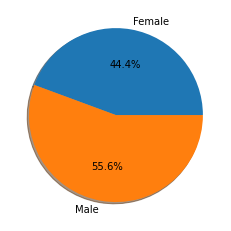

In [23]:
print('Gender')
labels = 'Female', 'Male'
sizes = [df.loc[df['Sex'] == True].shape[0], df.loc[df['Sex'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

In [ ]:
print('Remdesivir usage')
labels = 'Remdesivir', 'Not Remdesivir'
sizes = [df.loc[df['Remdesivir'] == True].shape[0], df.loc[df['Remdesivir'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

HTN


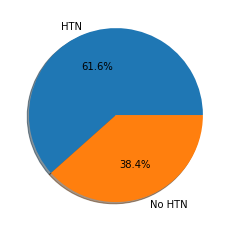

In [17]:
print('HTN')
labels = 'HTN', 'No HTN'
sizes = [df.loc[df['HTN'] == True].shape[0], df.loc[df['HTN'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

In [ ]:
print('HTN')
labels = 'HTN', 'No HTN'
sizes = [df.loc[df['HTN'] == True].shape[0], df.loc[df['HTN'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

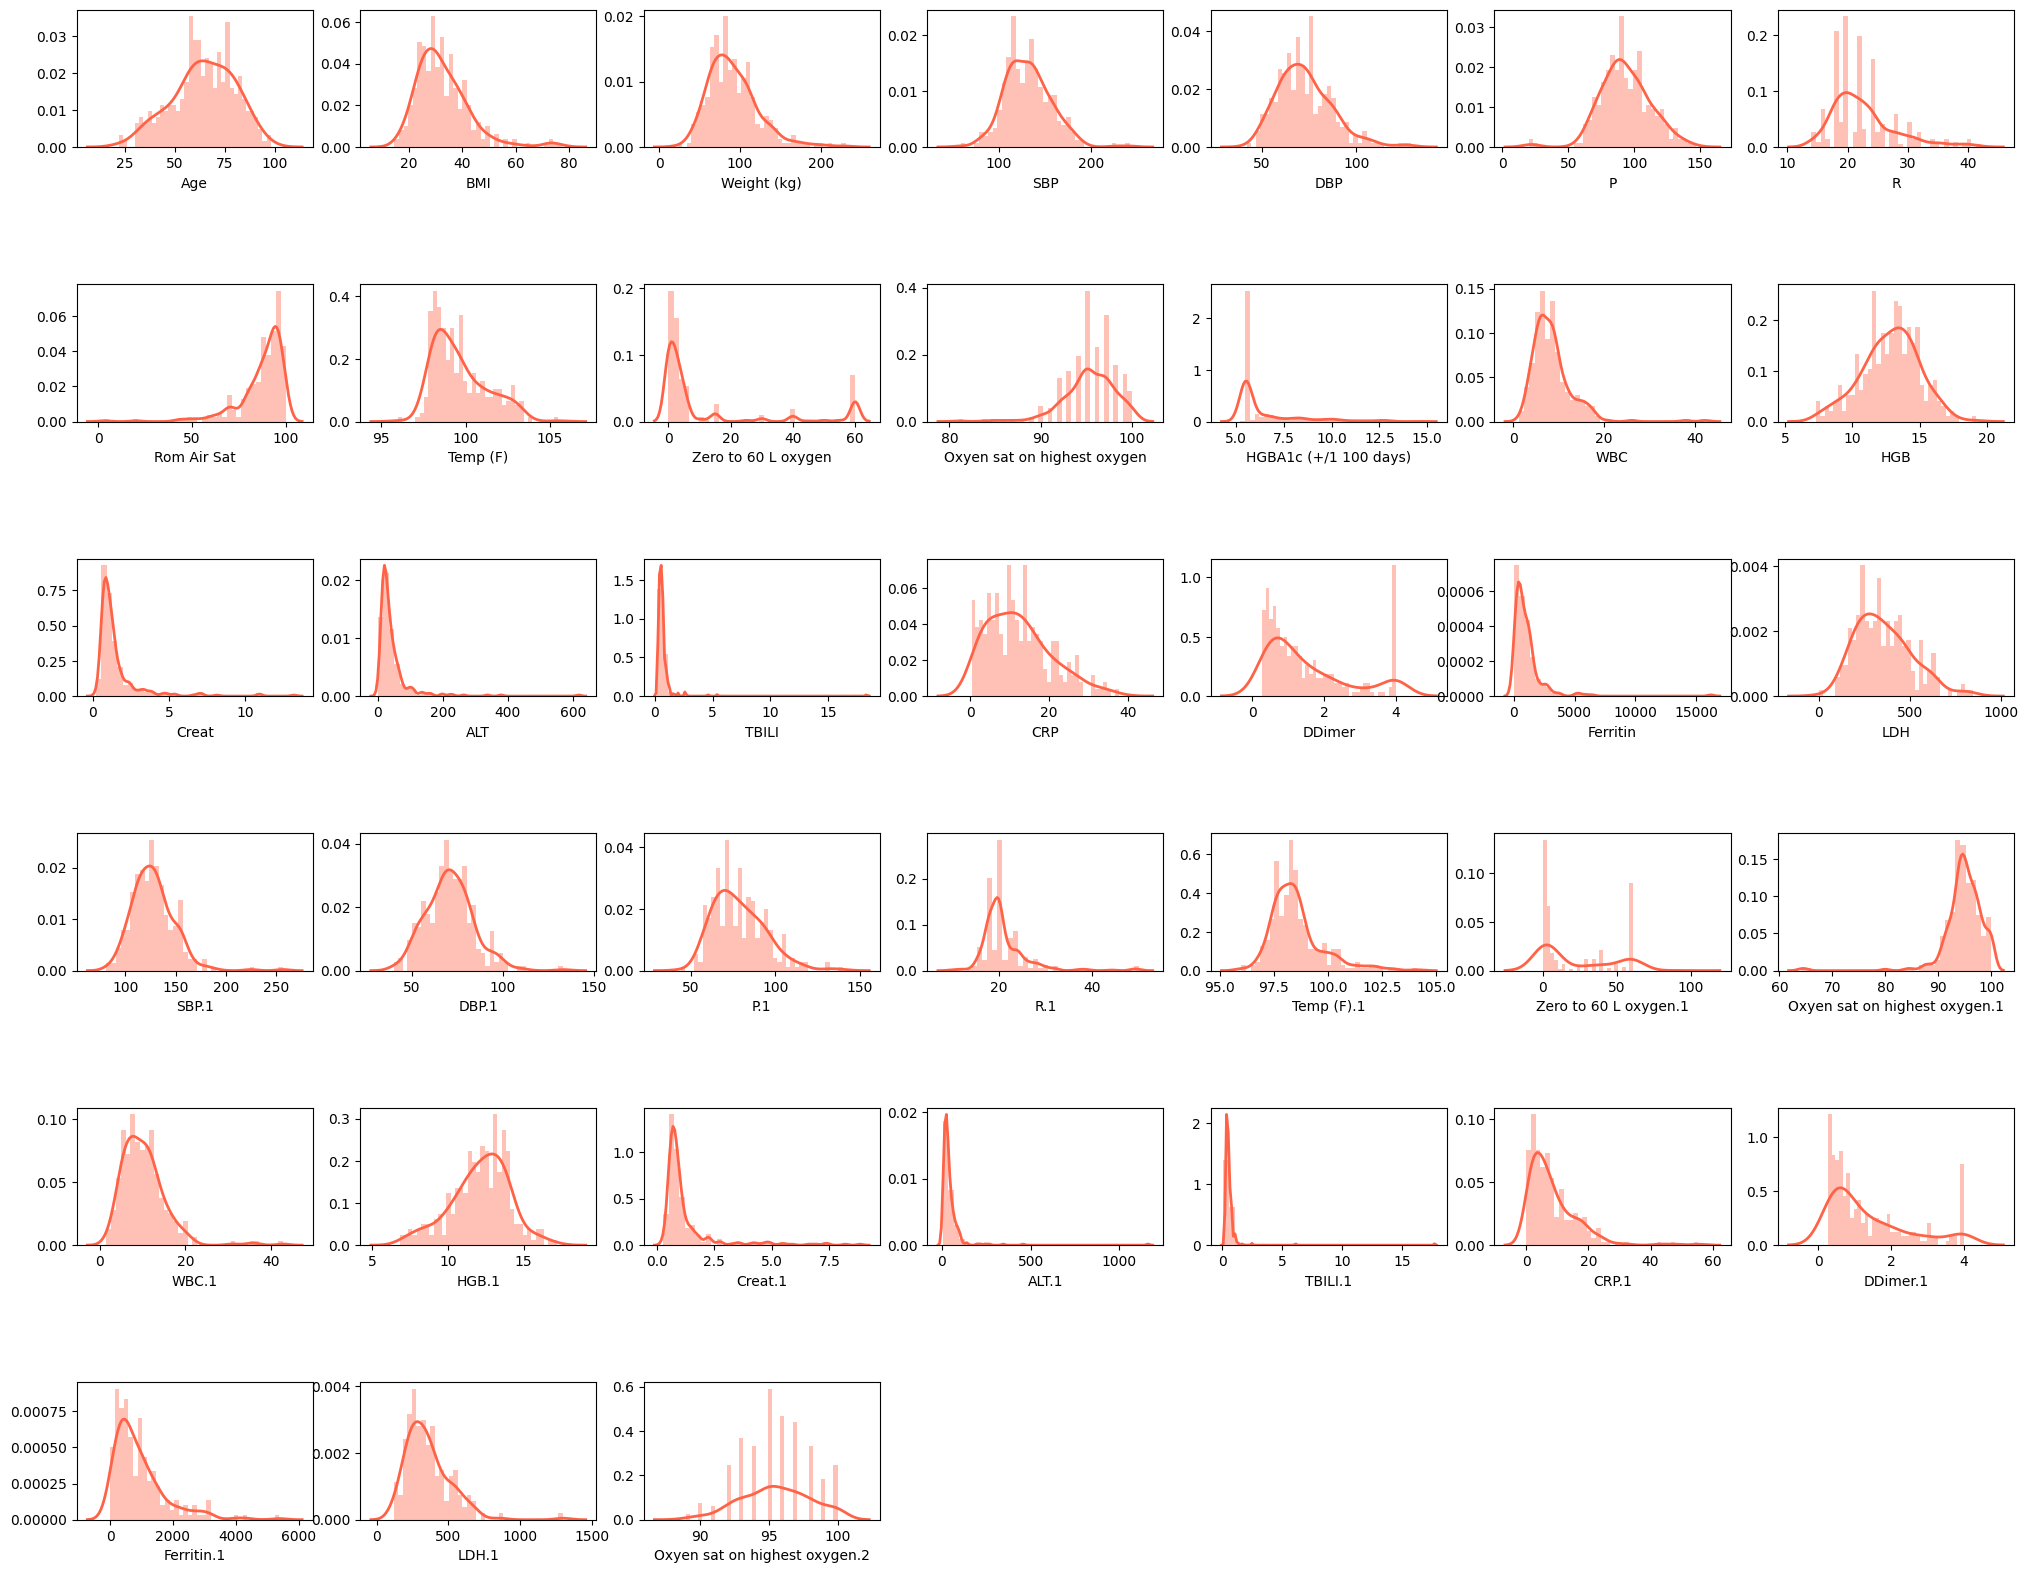

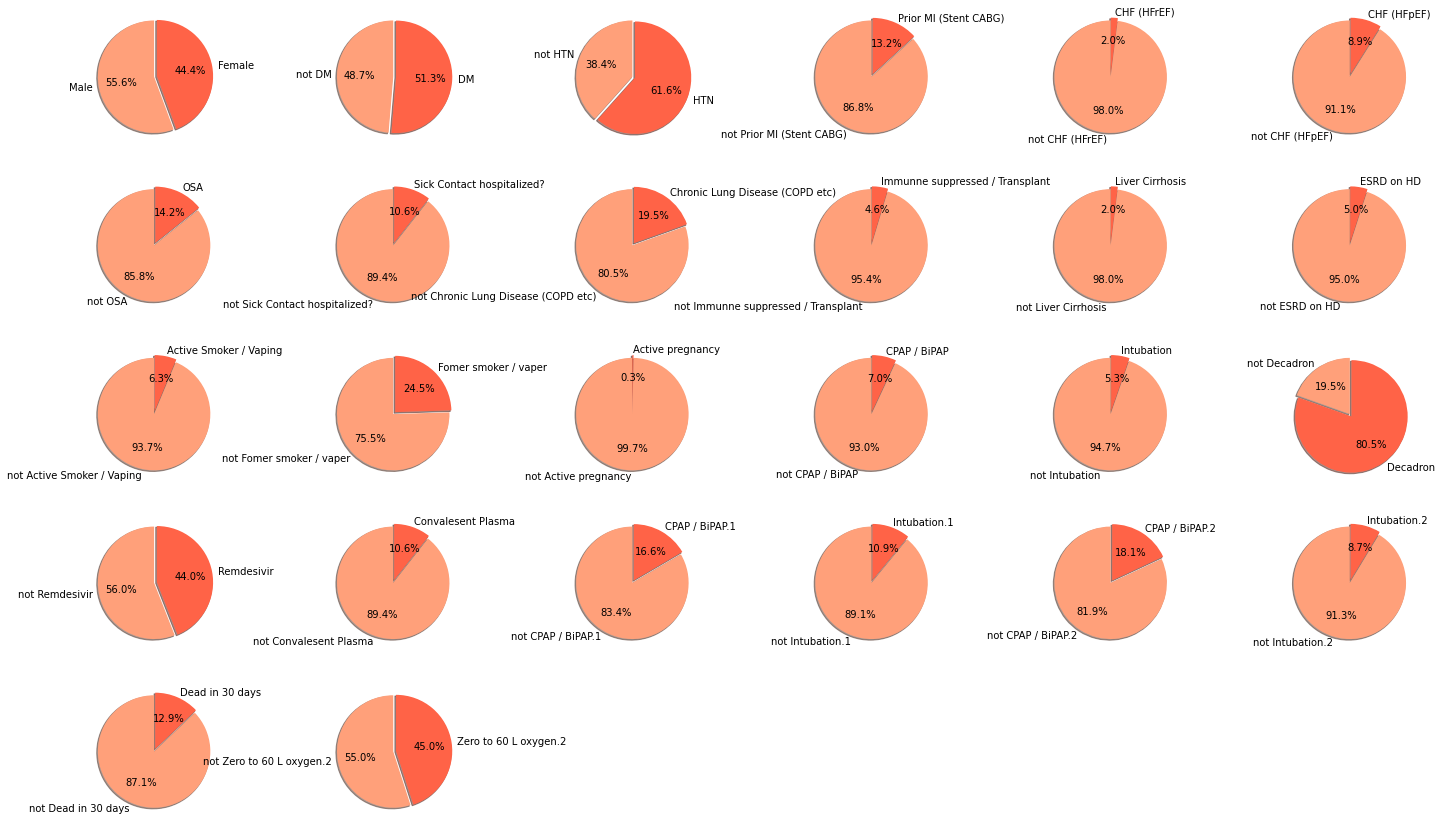

In [16]:
graphList = ['Age', 'BMI', 'Weight (kg)', 'SBP', 'DBP', 'P', 'R',
               'Rom Air Sat', 'Temp (F)', 'Zero to 60 L oxygen',
               'Oxyen sat on highest oxygen', 'HGBA1c (+/1 100 days)', 'WBC',
               'HGB', 'Creat', 'ALT', 'TBILI', 'CRP', 'DDimer',
               'Ferritin', 'LDH', 'SBP.1', 'DBP.1', 'P.1', 'R.1',
               'Temp (F).1', 'Zero to 60 L oxygen.1', 'Oxyen sat on highest oxygen.1',
               'WBC.1', 'HGB.1', 'Creat.1', 'ALT.1', 'TBILI.1',
               'CRP.1', 'DDimer.1', 'Ferritin.1', 'LDH.1',
                'Oxyen sat on highest oxygen.2']
graphs = plt.figure(figsize=(25,20),dpi=100)
plt.subplots_adjust(hspace=1)
#plt.title('Patient Data Distributions')
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(6,7,k)
    sns.distplot(df[graphList[k-1]], hist=True, kde=True, bins=int(len(df)/8), color = 'tomato', kde_kws={'linewidth': 2})
    #plt.ylabel('Frequency')
    #plt.title(graphList[k-1] + ' distribution')

"""Display some pie charts to visualize the binary data."""

pieList = ['DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
'OSA','Sick Contact hospitalized?','Chronic Lung Disease (COPD etc)','Immunne suppressed / Transplant',
'Liver Cirrhosis','ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy',
'CPAP / BiPAP','Intubation','Decadron','Remdesivir','Convalesent Plasma', 'CPAP / BiPAP.1', 'Intubation.1',
'CPAP / BiPAP.2','Intubation.2','Dead in 30 days', 'Zero to 60 L oxygen.2']
pie = plt.figure(figsize=(25,15))
#flipped charts: Remdesivir, Zero to 60 L oxygen.2
pie.add_subplot(5,6,1)
sizes = [df.loc[df['Sex'] == False].shape[0], df.loc[df['Sex'] == True].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Male', 'Female'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

for i in range(len(pieList)):
  pie.add_subplot(5,6, i+2)
  sizes = [df.loc[df[pieList[i]] == False].shape[0], df.loc[df[pieList[i]] == True].shape[0]]
  plt.pie(sizes, explode = (0,.05), labels=["not " + pieList[i], pieList[i]], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

Gender


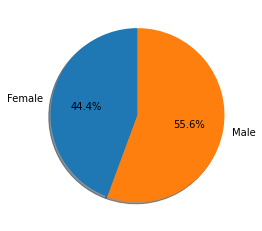

In [26]:
print('Gender')
labels = 'Female', 'Male'
sizes = [df.loc[df['Sex'] == True].shape[0], df.loc[df['Sex'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

HTN


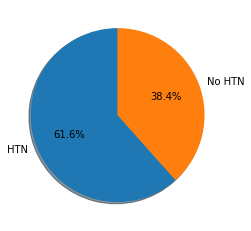

In [27]:
print('HTN')
labels = 'HTN', 'No HTN'
sizes = [df.loc[df['HTN'] == True].shape[0], df.loc[df['HTN'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Diabetes


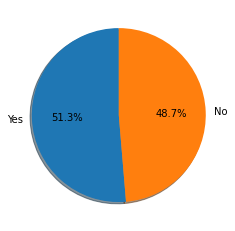

In [28]:
print('History of Diabetes')
labels = 'Yes', 'No'
sizes = [df.loc[df['DM'] == True].shape[0], df.loc[df['DM'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Hypertension


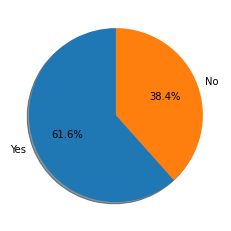

In [29]:
print('History of Hypertension')
labels = 'Yes', 'No'
sizes = [df.loc[df['HTN'] == True].shape[0], df.loc[df['HTN'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Coronary Artery Disease


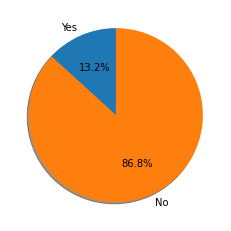

In [30]:
print('History of Coronary Artery Disease')
labels = 'Yes', 'No'
sizes = [df.loc[df['Prior MI (Stent CABG)'] == True].shape[0], df.loc[df['Prior MI (Stent CABG)'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of CHF (HFrEF)


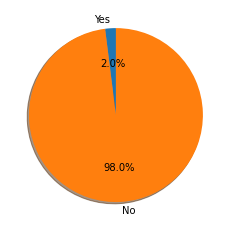

In [32]:
#CHF (HFrEF)
print('History of CHF (HFrEF)')
labels = 'Yes', 'No'
sizes = [df.loc[df['CHF (HFrEF)'] == True].shape[0], df.loc[df['CHF (HFrEF)'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of CHF (HFpEF)


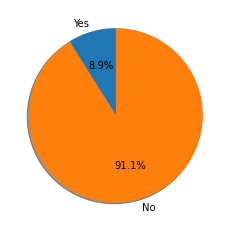

In [33]:
print('History of CHF (HFpEF)')
labels = 'Yes', 'No'
sizes = [df.loc[df['CHF (HFpEF)'] == True].shape[0], df.loc[df['CHF (HFpEF)'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of OSA


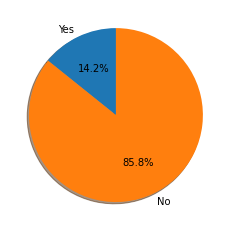

In [34]:
print('History of OSA')
labels = 'Yes', 'No'
sizes = [df.loc[df['OSA'] == True].shape[0], df.loc[df['OSA'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Exposure of Hospitalized Contact


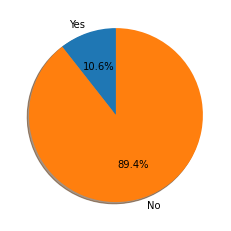

In [35]:
print('Exposure of Hospitalized Contact')
labels = 'Yes', 'No'
sizes = [df.loc[df['Sick Contact hospitalized?'] == True].shape[0], df.loc[df['Sick Contact hospitalized?'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Chronic Lung Disease


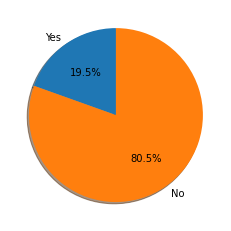

In [36]:
print('History of Chronic Lung Disease')
labels = 'Yes', 'No'
sizes = [df.loc[df['Chronic Lung Disease (COPD etc)'] == True].shape[0], df.loc[df['Chronic Lung Disease (COPD etc)'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Immune Suppressed State


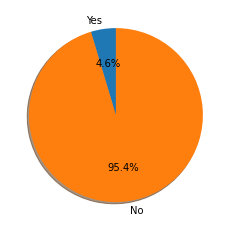

In [38]:
print('Immune Suppressed State')
labels = 'Yes', 'No'
sizes = [df.loc[df['Immunne suppressed / Transplant'] == True].shape[0], df.loc[df['Immunne suppressed / Transplant'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Liver Cirrhosis


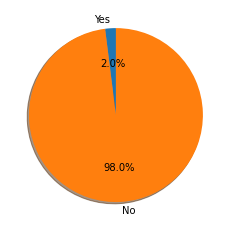

In [39]:
print('History of Liver Cirrhosis')
labels = 'Yes', 'No'
sizes = [df.loc[df['Liver Cirrhosis'] == True].shape[0], df.loc[df['Liver Cirrhosis'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of End Stage Renal Disease on Dialysis


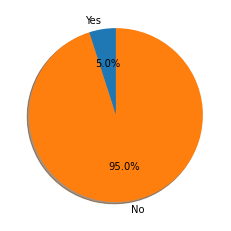

In [40]:
print('History of End Stage Renal Disease on Dialysis')
labels = 'Yes', 'No'
sizes = [df.loc[df['ESRD on HD'] == True].shape[0], df.loc[df['ESRD on HD'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Active Smoker


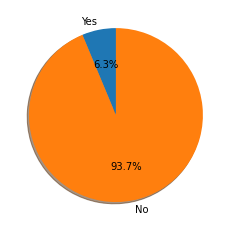

In [41]:
print('Active Smoker')
labels = 'Yes', 'No'
sizes = [df.loc[df['Active Smoker / Vaping'] == True].shape[0], df.loc[df['Active Smoker / Vaping'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

History of Smoking


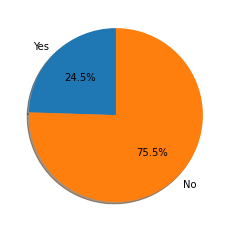

In [45]:
print('History of Smoking')
labels = 'Yes', 'No'
sizes = [df.loc[df['Fomer smoker / vaper'] == True].shape[0], df.loc[df['Fomer smoker / vaper'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Active Pregnancy


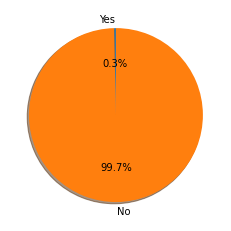

In [47]:
print('Active Pregnancy')
labels = 'Yes', 'No'
sizes = [df.loc[df['Active pregnancy'] == True].shape[0], df.loc[df['Active pregnancy'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

CPAP / BiPAP Use in 24 Hours


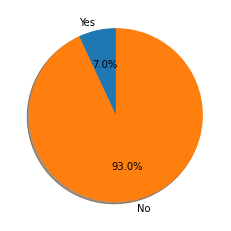

In [48]:
print('CPAP / BiPAP Use in 24 Hours')
labels = 'Yes', 'No'
sizes = [df.loc[df['CPAP / BiPAP'] == True].shape[0], df.loc[df['CPAP / BiPAP'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Intubation in 24 Hours


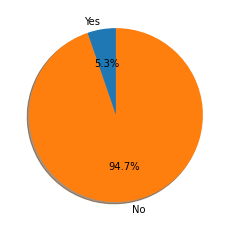

In [49]:
print('Intubation in 24 Hours')
labels = 'Yes', 'No'
sizes = [df.loc[df['Intubation'] == True].shape[0], df.loc[df['Intubation'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Decadron Administration


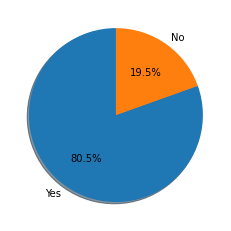

In [51]:
print('Decadron Administration')
labels = 'Yes', 'No'
sizes = [df.loc[df['Decadron'] == True].shape[0], df.loc[df['Decadron'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Remdesivir Administration


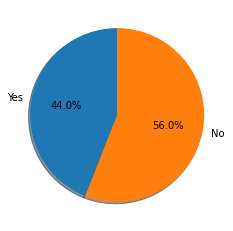

In [52]:
print('Remdesivir Administration')
labels = 'Yes', 'No'
sizes = [df.loc[df['Remdesivir'] == True].shape[0], df.loc[df['Remdesivir'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Convalesent Plasma


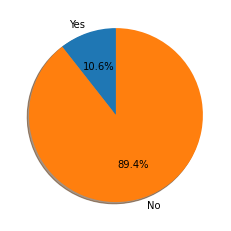

In [53]:
print('Convalesent Plasma')
labels = 'Yes', 'No'
sizes = [df.loc[df['Convalesent Plasma'] == True].shape[0], df.loc[df['Convalesent Plasma'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

CPAP / BiPAP Use in 48 Hours


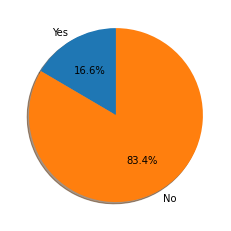

In [54]:
print('CPAP / BiPAP Use in 48 Hours')
labels = 'Yes', 'No'
sizes = [df.loc[df['CPAP / BiPAP.1'] == True].shape[0], df.loc[df['CPAP / BiPAP.1'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Intubation in 48 Hours


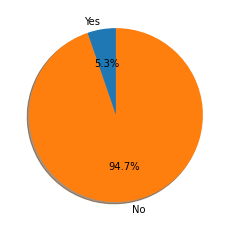

In [55]:
print('Intubation in 48 Hours')
labels = 'Yes', 'No'
sizes = [df.loc[df['Intubation'] == True].shape[0], df.loc[df['Intubation'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

30 Day Mortality


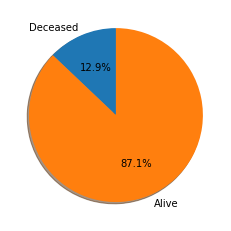

In [57]:
print('30 Day Mortality')
labels = 'Deceased', 'Alive'
sizes = [df.loc[df['Dead in 30 days'] == True].shape[0], df.loc[df['Dead in 30 days'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Advanced Oxygen Requirement in 96 HYours


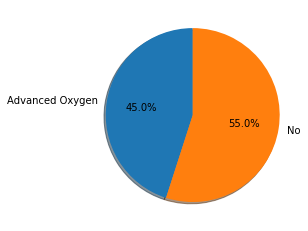

In [59]:
print('Advanced Oxygen Requirement in 96 HYours')
labels = 'Advanced Oxygen', 'No'
sizes = [df.loc[df['Zero to 60 L oxygen.2'] == True].shape[0], df.loc[df['Zero to 60 L oxygen.2'] == False].shape[0]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()